<a href="https://colab.research.google.com/github/thedatasense/llm-healthcare/blob/main/App-C%20-%20Building%20LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building LLM from Scratch

This part is heavily inspired based on the work by Sebastian Raschka <br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>


In [32]:
!pip install tiktoken

In [33]:
from importlib.metadata import version
import os
import urllib.request
import importlib
import tiktoken
import torch
import pandas as pd
from torch.utils.data import DataLoader
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.2.2
tiktoken version: 0.8.0


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.set_device(1)  # Set GPU 1 as the active device
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")

Using mps device.


### Dataset

The dataset is from a [Kaggle Medical Text dataset](https://www.kaggle.com/datasets/chaitanyakck/medical-text) dataset that is from abstracts written during routine rounds by doctors explaining the current conditions of the patient

In [35]:
df = pd.read_csv("https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/refs/heads/main/medical_tc_train.csv")
df.head()

,condition_label,medical_abstract
0,5,"Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic interventions with the ultimate hope of stopping or slowing the loosening process."
1,1,"Neuropeptide Y and neuron-specific enolase levels in benign and malignant pheochromocytomas. Neuron-specific enolase (NSE) is the isoform of enolase, a glycolytic enzyme found in the neuroendocrine system. Neuropeptide Y (NPY) is a peptide recently discovered in the peripheral and central nervous systems. Serum NSE and plasma NPY levels have been reported to be increased in some patients with pheochromocytoma. The authors evaluated whether the measurement of these molecules could help to discriminate between benign and malignant forms of pheochromocytoma. The NSE levels were normal in all patients with benign pheochromocytoma (n = 13) and elevated in one half of those with malignant pheochromocytoma (n = 13). Plasma NPY levels were on the average significantly higher in the malignant (177.1 +/- 38.9 pmol/l, n = 16) than in the benign forms of the disease (15.7 +/- 389 pmol/l, n = 24). However, there was no difference in the percentage of patients with elevated NPY levels. These results show that determination of serum NSE may be useful for distinguishing between malignant and benign pheochromocytoma; the measurement of plasma NPY is not useful for differentiating the two kinds of tumors."
2,2,"Sexually transmitted diseases of the colon, rectum, and anus. The challenge of the nineties. During the past two decades, an explosive growth in both the prevalence and types of sexually transmitted diseases has occurred. Up to 55 percent of homosexual men with anorectal complaints have gonorrhea; 80 percent of the patients with syphilis are homosexuals. Chlamydia is found in 15 percent of asymptomatic homosexual men, and up to one third of homosexuals have active anorectal herpes simplex virus. In addition, a host of parasites, bacterial, viral, and protozoan are all rampant in the homosexual population. Furthermore, the global epidemic of AIDS has produced a plethora of colorectal manifestations. Acute cytomegalovirus ileocolitis is the most common indication for emergency abdominal surgery in the homosexual AIDS population. Along with cryptosporidia and isospora, the patient may present to the colorectal surgeon with bloody diarrhea and weight loss before the diagnosis of human immunodeficiency virus (HIV) disease. Other patients may present with colorectal Kaposi's sarcoma or anorectal lymphoma, and consequently will be found to have seropositivity for HIV. However, in addition to these protean manifestations, one third of patients with AIDS consult the colorectal surgeon with either condylomata acuminata, anorectal sepsis, or proctitis before the diagnosis of HIV disease. Although aggressive anorectal surgery is associated with reasonable surgical results in some asymptomatic HIV positive patients, the same procedures in AIDS (symptomatic HIV positive) patients will often be met with disastrous results. It is incumbent upon the surgeon, therefore, to r

In [36]:
medical_abstracts = df['medical_abstract'].astype(str).tolist()  # Extract the column and convert to a list of strings
text_data = ' '.join(medical_abstracts)  # Combine all abstracts into a single string
# Display the total number of characters and a preview of the combined text
print("Total number of characters:", len(text_data))
print(text_data[300:700])

Total number of characters: 14207702
olated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of rev


### GPT-2 Tokenization: Byte-Pair Encoding ###

- GPT-2 used Byte-Pair Encoding  as its tokenizer.
- It allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words.
- For instance, if GPT-2’s vocabulary doesn’t have the word *"unfamiliarword"*, it might tokenize it as `["unfam", "iliar", "word"]` or some other subword breakdown, depending on its trained BPE merges.
- The original BPE tokenizer can be found here: [https://github.com/openai/gpt-2/blob/master/src/encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)


In [37]:
tokenizer = tiktoken.get_encoding("cl100k_base")
enc_text = tokenizer.encode(text_data)
print("Total number of character:", len(enc_text))

Total number of character: 3055877


In [38]:
enc_text[0:5]

[51, 11407, 4442, 2212, 20784]

In [39]:
context_size = 10
enc_sample = enc_text[200:]
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:      {y}")

# what are we expecting the model to predict based on the context
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

x: [6147, 1920, 13, 220, 4275, 4176, 47309, 816, 323, 49384]
y:      [1920, 13, 220, 4275, 4176, 47309, 816, 323, 49384, 19440]
ening ---->  process
ening process ----> .
ening process. ---->  
ening process.  ---->  Ne
ening process.  Ne ----> urope
ening process.  Neurope ----> ptide
ening process.  Neuropeptide ---->  Y
ening process.  Neuropeptide Y ---->  and
ening process.  Neuropeptide Y and ---->  neuron
ening process.  Neuropeptide Y and neuron ----> -specific


In [40]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
#Characters:→ Total raw characters in our text data.
print("Characters:", total_characters)
#Tokens:→ Number of units after applying the tokenizer (subwords, spaces, punctuation and so on)
print("Tokens:", total_tokens)

Characters: 14207702
Tokens: 3055877


### Dataset

In [59]:
class MedCorpusDataset(torch.utils.data.Dataset):
    def __init__(self,txt,tokenizer,max_len,stride):
        self.input_ids = []
        self.output_ids = []
        token_ids = tokenizer.encode(txt,allowed_special={"<|endoftext|>"})
        # lets use a sliding window to chunk the text in to overlapping sequences of maximum length
        for i in range (0,len(token_ids) - max_len,stride):
            input_chunk = token_ids[i:i+max_len]
            target_chunk = token_ids[i+1 :i+max_len+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.output_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.output_ids[idx]



Here we will code the architecture of the smallest GPT-2 model (124 million parameters), as outlined in Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer
- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings covered
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism implemented
- `"n_layers"` is the number of transformer blocks within the model
- `"drop_rate"` is the dropout mechanism's intensity,.1 means dropping 10% of hidden units during training to mitigate overfitting
- `"qkv_bias"` decides if the `Linear` layers in the multi-head attention mechanism should include a bias vector when computing query (Q), key (K), and value (V) tensors;

In [60]:
def data_loader(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
    tokenizer = tiktoken.get_encoding("cl100k_base")
    dataset = MedCorpusDataset(txt,tokenizer,max_length,stride)
    dataloader = DataLoader (
        dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
    return dataloader

### Transformer Architecture Setup

*   **Multi-Head Attention** learns relationships between inputs by projecting them into **queries**, **keys**, and **values**.
*   Input is split into multiple **heads**, each learning different attention patterns.
*   **Scaled dot-product attention** calculates similarity between queries and keys, creating attention weights.
*   A **causal mask** prevents the model from attending to future tokens in sequence generation.
*   Outputs from all heads are concatenated and projected, providing a context-aware representation.


In [61]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Dimension of each attention head

        # Linear projections for query, key, and value
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)

        # Causal mask to prevent attending to future tokens
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape  # Batch size, sequence length, input dimension

        # Project the input to query, key, and value
        keys = self.W_key(x)     # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x) # Shape: (b, num_tokens, d_out)
        values = self.W_value(x) # Shape: (b, num_tokens, d_out)

        # Split the projected vectors into multiple heads
        # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose to prepare for matrix multiplication
        # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Calculate attention scores (scaled dot-product attention)
        attn_scores = queries @ keys.transpose(2, 3)  # Shape: (b, num_heads, num_tokens, num_tokens)

        # Apply causal mask to attention scores
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Truncate mask to current sequence length
        attn_scores = attn_scores.masked_fill(mask_bool, float('-inf')) # Mask out future tokens

        # Normalize attention scores with softmax
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1) # Scale by sqrt(head_dim)

        # Apply dropout to attention weights
        attn_weights = self.dropout(attn_weights)

        # Calculate the weighted sum of values
        # (b, num_heads, num_tokens, num_tokens) @ (b, num_heads, num_tokens, head_dim) -> (b, num_heads, num_tokens, head_dim)
        context_vec = attn_weights @ values

        # Concatenate the outputs from all heads
        # (b, num_heads, num_tokens, head_dim) -> (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)

        # Reshape to combine heads: (b, num_tokens, num_heads, head_dim) -> (b, num_tokens, d_out)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)

        # Apply final linear projection
        context_vec = self.out_proj(context_vec)

        return context_vec

### GELU Activation Function

The **Gaussian Error Linear Unit (GELU)** is an activation function defined as:

$
\text{GELU}(x) = x \cdot \Phi(x)
$

where \(\Phi(x)\) is the cumulative distribution function (CDF) of the standard normal distribution:

$
\Phi(x) = 0.5 \cdot \left(1 + \text{tanh}\left(\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right)\right)
$



In [62]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


In [63]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [64]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

### Transformer Block

#### 1. Multi-Head Attention (`self.att`)

*   **Purpose:** This is where the model learns to "attend" to different parts of the input sequence. It calculates relationships between words (or tokens) in the sequence, regardless of their distance. This is crucial for understanding context and long-range dependencies.
*   **How it works:**
    *   The input `x` is projected into three different representations: **queries (Q)**, **keys (K)**, and **values (V)**.
    *   The model calculates **attention scores** by taking the dot product of queries and keys, scaled down by the square root of the key dimension.
    *   These scores are passed through a softmax to get **attention weights**, representing the importance of each word to every other word.
    *   The attention weights are used to compute a weighted sum of the values, producing the **context vector**.
    *   This process is done multiple times in parallel with different learned projections (**multiple heads**), allowing the model to capture diverse relationships.
*   **Why it's important:** Unlike recurrent models (like RNNs), self-attention can process the entire sequence in parallel, making it much faster. It also directly models relationships between any two words, regardless of their position, which helps with long-range dependencies.

#### 2. Feed-Forward (`self.ff`)

*   **Purpose:** A simple, fully connected feed-forward network that processes each token's representation independently. This adds non-linearity and further transforms the information learned by the attention mechanism.
*   **How it works:** Typically, it consists of two linear layers with a non-linear activation function (like GELU or ReLU) in between.
*   **Why it's important:** It provides additional processing power and allows the model to learn more complex patterns from the attention outputs.

#### 3. LayerNorm (`self.norm1`, `self.norm2`)

*   **Purpose:** Layer normalization normalizes the activations across the feature dimension (embedding dimension). It helps stabilize training and can improve performance.
*   **How it works:** It subtracts the mean and divides by the standard deviation of the activations within each individual embedding vector (across the embedding dimension).
*   **Why it's important:** It prevents the activations from becoming too large or too small, which can lead to unstable gradients during training. It also makes the model less sensitive to the scale of the input features.

#### 4. Dropout (`self.drop_shortcut`)

*   **Purpose:** A regularization technique that randomly sets a fraction of the activations to zero during training. This helps prevent overfitting.
*   **How it works:** During each forward pass, it randomly "drops out" (sets to zero) a certain percentage of the activations, determined by the `drop_rate`.
*   **Why it's important:** It forces the model to learn more robust features that are not overly reliant on any single activation.

#### 5. Residual Connections (Shortcut Connections)

*   **Purpose:** The output of each sub-block (MHA and FFN) is added to its original input (`x = x + shortcut`). This helps with the flow of gradients during training, especially in deep networks.
*   **How it works:** The original input `x` is added to the output of the sub-block before being passed to the next layer.
*   **Why it's important:**
    *   **Vanishing Gradients:** In very deep networks, gradients can become very small as they are backpropagated through many layers, making training difficult. Residual connections provide a "shortcut" for the gradients to flow back, mitigating this problem.
    *   **Identity Mapping:** They make it easier for the network to learn the identity function (where the output is the same as the input). This is because if a layer is not needed, the network can easily learn to set its weights to zero, effectively making it pass through the input unchanged.

#### `forward(self, x)` Method:

The `forward` method defines how the input `x` is processed through the `TransformerBlock`:

1.  **Attention Block:**
    *   Store the original input for the residual connection.
    *   Apply layer normalization.
    *   Pass through the multi-head attention mechanism.
    *   Apply dropout to the output of the attention block
    *   Add the original input back (residual connection).

2.  **Feed-Forward Block:**
    *   Store the output from the attention block for the residual connection.
    *   Apply layer normalization.
    *   Pass through the feed-forward network.
    *   Apply dropout to the output of the feed-forward block.
    *   Add the output from the attention block back (residual connection).

3.  Return the processed output.

**In essence, the `TransformerBlock` takes an input sequence, allows it to attend to itself, processes it further with a feed-forward network, and uses layer normalization and residual connections to improve training and performance. Multiple `TransformerBlock` instances are stacked together to create the full Transformer model.**


In [65]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [66]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [68]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 512, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [69]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = data_loader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = data_loader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [84]:
def generate_text(model, idx, max_new_tokens, context_size, temperature=1.0):
    """
    Generate text token-by-token using an autoregressive language model.
    """
    for _ in range(max_new_tokens):
        # Use only the most recent context
        idx_cond = idx[:, -context_size:]

        # Get model predictions
        with torch.no_grad():
            logits = model(idx_cond)[:, -1, :]  # Get logits for the last token

        # Apply temperature scaling
        logits /= temperature

        # Convert logits to probabilities and sample the next token
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)  # Sample from the probability distribution

        # Append the sampled token to the sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx


In [85]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "It is recommended to take rest when"
tokenizer = tiktoken.get_encoding("cl100k_base")

token_ids = generate_text(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)



In [86]:
print("Untrained Model Says This :\n", token_ids_to_text(token_ids, tokenizer))

Untrained Model Says This :
 It is recommended to take rest whenestructorCompany="#" QUE Pick]



	cur.Doc labelscop


In [87]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [88]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 2750464
Validation tokens: 305152
All tokens: 3055616


In [95]:
def calc_loss_batch(input_batch, target_batch, model, device):
    """
     Computes the loss for a single batch of input and target data.
    :param input_batch:
    :param target_batch:
    :param model:
    :param device:
    :return:
    """
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [96]:
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.108678046572324
Validation loss: 10.107906194341263


In [97]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:

import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 7
train_losses, val_losses, tokens_seen = train_model(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="patient has high", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.396, Val loss 9.405
Ep 1 (Step 000005): Train loss 7.986, Val loss 8.031
Ep 1 (Step 000010): Train loss 7.108, Val loss 7.259
Ep 1 (Step 000015): Train loss 6.982, Val loss 7.000
Ep 1 (Step 000020): Train loss 7.063, Val loss 6.948
Ep 1 (Step 000025): Train loss 7.065, Val loss 6.872
Ep 1 (Step 000030): Train loss 6.524, Val loss 6.746
Ep 1 (Step 000035): Train loss 6.680, Val loss 6.705


In [150]:
torch.save(model.state_dict(),"./models/basic_llm_med.pth")

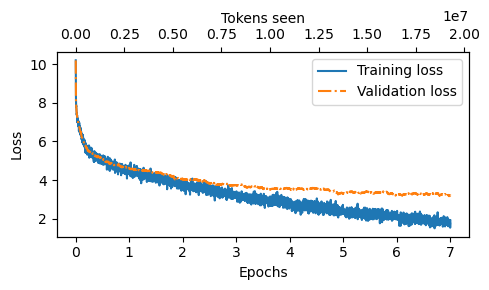

In [149]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [4]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("The effect of smoking", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

NameError: name 'model' is not defined

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

**Top-k and Temperature**

 **Top-k** limits the model's choice to the *k* most probable next words, discarding less likely options. **Temperature** scales the probability distribution; higher values increase randomness by making the distribution more uniform, while lower values favor the most likely word by making it more peaked.  For instance, when creating a poem, high temperature with low Top-k might yield unusual word choices. Conversely, low temperature with high Top-k would produce a more predictable, coherent verse.  In essence, they dictate how "focused" versus "creative" the generated text becomes.

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you, I will spare for you. Here it was much
a gentleman and


In [ ]:
torch.save(model.state_dict(), "model.pth")